In [1]:
import torch
import intel_extension_for_pytorch as ipex
from torch import nn as nn
from torch import Tensor
import math
from glob import glob
from torchinfo import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import cohen_kappa_score
from PIL import Image 

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

print(f'Using device: {device}')

/home/pedro/Repositories/dl-larvae/.venv/lib/python3.12/site-packages/intel_extension_for_pytorch/transformers/optimize.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[W705 16:40:51.142988585 OperatorEntry.cpp:154] Warning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::_addmm_activation(Tensor self, Tensor mat1, Tensor mat2, *, Scalar beta=1, Scalar alpha=1, bool use_gelu=False) -> Tensor
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: AutocastCPU
  previous kernel: registered at /pytorch/aten/src/ATen/autocast_mode.cpp:327
       new kernel: registered at /opt/workspace/ipex-cpu-dev/csrc/cp

Using device: cpu


### Randomly split a fileset into training, validation, and test sets: output lists of image names

In [ ]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '../larvae'
nclasses   = 2

# Set the desired image size for rescaling and maximum value for normalization

width       = 224 
height      = 224
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

number_of_class_1 = 247
number_of_class_2 = 1351

# Set the percentages of samples that will be used for training, validation and test. 

train_perc = 0.20
valid_perc = 0.10
test_perc  = 0.05

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.png") # it returns a list of image filenames

num_train_samples = int(len(data)*train_perc)
num_valid_samples = int(len(data)*valid_perc)  
num_test_samples  = int((len(data) - num_train_samples - num_valid_samples)*test_perc)
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples] 
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:num_train_samples+num_valid_samples+num_test_samples]

print("------------------------------------------")
print(f"Total number of images:      {len(data)}")
print(f"Number of train images:      {len(trainset)}")
print(f"Number of validation images: {len(validset)}")
print(f"Number of test images:       {len(testset)}")
print("------------------------------------------")
# Set output model name

model_name  = 'BasicCNN.pth'

------------------------------------------
Total number of images:      1598
Number of train images:      319
Number of validation images: 159
Number of test images:       56
------------------------------------------


### Create image datasets with some preprocessing: output a list of image tensors

In [4]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset_filenames, transform=None): # Renamed dataset to dataset_filenames for clarity
        # it gets the image true labels and set the preprocessing transformation
        self.dataset = dataset_filenames
        print(self.dataset)
        self.targets = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)
    def __getitem__(self, ix): # returns the item at position ix
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename).convert("RGB") # Ensure image is in RGB
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            # Ensure proper handling if no transform is applied - e.g., if it's a grayscale image
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()
        return(image,target)

In [5]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

['../larvae/000002_00001054.png', '../larvae/000002_00001350.png', '../larvae/000002_00001089.png', '../larvae/000001_00000033.png', '../larvae/000001_00000054.png', '../larvae/000001_00000069.png', '../larvae/000002_00000637.png', '../larvae/000002_00000815.png', '../larvae/000002_00000530.png', '../larvae/000001_00000095.png', '../larvae/000002_00000953.png', '../larvae/000002_00000507.png', '../larvae/000002_00000770.png', '../larvae/000002_00001265.png', '../larvae/000002_00000619.png', '../larvae/000002_00001173.png', '../larvae/000002_00000116.png', '../larvae/000002_00000370.png', '../larvae/000002_00000524.png', '../larvae/000002_00000129.png', '../larvae/000002_00000180.png', '../larvae/000002_00001215.png', '../larvae/000001_00000167.png', '../larvae/000002_00000178.png', '../larvae/000002_00000565.png', '../larvae/000002_00001191.png', '../larvae/000002_00000495.png', '../larvae/000002_00001206.png', '../larvae/000002_00000063.png', '../larvae/000001_00000087.png', '../larva

In [6]:
print(trainset[0][0].shape, trainset[0][1]) # print the shape of the first image and its label

torch.Size([3, 224, 224]) 1


### Visualize selected images

Number of images: 319
Images are 224x224x3
Class of the image:  2


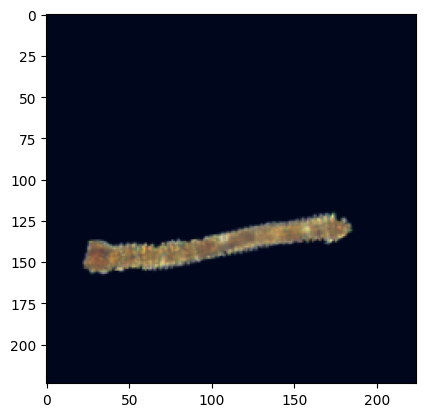

In [7]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[1] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

### Generate batches with batchsize images at random

In [8]:
batchsize = 32
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload)) # inspect next item in the trainload

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

### ConvNet model

In [9]:
# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer 
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1, bias=False),
        #defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class CorelNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(CorelNet, self).__init__()
        
        #defining feature extractor
        self.features = nn.Sequential(
            conv_block(input_shape[0],8,2),
            conv_block(8,16,2)
        )

        #defining classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=input_shape[1]//4*input_shape[2]//4*16, out_features=16, bias=True),
            nn.ReLU(),
            nn.Linear(16, nclasses)
        )

        #initialize weights
        self._initialize_weights()

    def forward(self, x):
       #extracts features
        x = self.features(x)

        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
  
        return y
  
    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels    
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()

### Create the model

In [10]:
model = CorelNet(input_shape, nclasses).to(device)
summary(model,input_size=(1, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
CorelNet                                 [1, 2]                    --
├─Sequential: 1-1                        [1, 16, 56, 56]           --
│    └─Sequential: 2-1                   [1, 8, 112, 112]          --
│    │    └─Conv2d: 3-1                  [1, 8, 224, 224]          216
│    │    └─BatchNorm2d: 3-2             [1, 8, 224, 224]          16
│    │    └─ReLU: 3-3                    [1, 8, 224, 224]          --
│    │    └─MaxPool2d: 3-4               [1, 8, 112, 112]          --
│    └─Sequential: 2-2                   [1, 16, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 16, 112, 112]         1,152
│    │    └─BatchNorm2d: 3-6             [1, 16, 112, 112]         32
│    │    └─ReLU: 3-7                    [1, 16, 112, 112]         --
│    │    └─MaxPool2d: 3-8               [1, 16, 56, 56]           --
├─Sequential: 1-2                        [1, 2]                    --
│    └─Line

### Define the loss function with L2 regularization

In [11]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # add l2_regularization            
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc

# criterion = Criterion

weights = Tensor([1.0, number_of_class_1 / number_of_class_2]) # Adjust weights based on class imbalance
criterion = nn.CrossEntropyLoss(weight=weights)

### Define optimizer and learning scheduler

In [12]:
optimizer    = optim.Adam(model.parameters(), lr=3e-4)
# gamma=0.1 is a multiplicative factor for lr decay at every epoch
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
# gamma=0.1 is a multiplicative factor for lr decay at every step_size=number of epochs
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [13]:
# Optimize model and optimizer for Intel hardware using IPEX
# model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=None, inplace=True)

### Clean up memory if needed

In [ ]:
import gc
# del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

### Define training and validation functions

In [15]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss    = criterion(preds, targets)
    
    # Calculate accuracy
    acc = (preds.argmax(dim=1) == targets).float().mean()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss    = criterion(preds, targets)

    acc = (preds.argmax(dim=1) == targets).float().mean()

    return loss.item(), acc.item()

### Train the model and report the results

In [16]:
# initializing variables
n_epochs = 100
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0: log.report_avgs(ex+1)
    #count epochs for auto-adjusting the learning rate
    lr_scheduler.step()

EPOCH: 10.000  val_loss: 0.638  trn_loss: 0.557  trn_acc: 0.667  val_acc: 0.535  (77.10s - 693.87s remaining)
EPOCH: 20.000  val_loss: 0.663  trn_loss: 0.525  trn_acc: 0.802  val_acc: 0.610  (156.15s - 624.59s remaining)
EPOCH: 30.000  val_loss: 0.538  trn_loss: 0.498  trn_acc: 0.765  val_acc: 0.654  (234.94s - 548.19s remaining)
EPOCH: 40.000  val_loss: 0.597  trn_loss: 0.496  trn_acc: 0.793  val_acc: 0.635  (314.11s - 471.16s remaining)
EPOCH: 50.000  val_loss: 0.618  trn_loss: 0.471  trn_acc: 0.809  val_acc: 0.616  (394.50s - 394.50s remaining)
EPOCH: 60.000  val_loss: 0.616  trn_loss: 0.463  trn_acc: 0.809  val_acc: 0.648  (474.86s - 316.57s remaining)
EPOCH: 70.000  val_loss: 0.549  trn_loss: 0.470  trn_acc: 0.809  val_acc: 0.610  (555.36s - 238.01s remaining)
EPOCH: 80.000  val_loss: 0.596  trn_loss: 0.475  trn_acc: 0.803  val_acc: 0.735  (635.85s - 158.96s remaining)
EPOCH: 90.000  val_loss: 0.559  trn_loss: 0.460  trn_acc: 0.786  val_acc: 0.654  (718.30s - 79.81s remaining)
EPO

### Plot the results

  0%|          | 0/201 [00:00<?, ?it/s]

100%|██████████| 201/201 [00:00<00:00, 2511.62it/s]


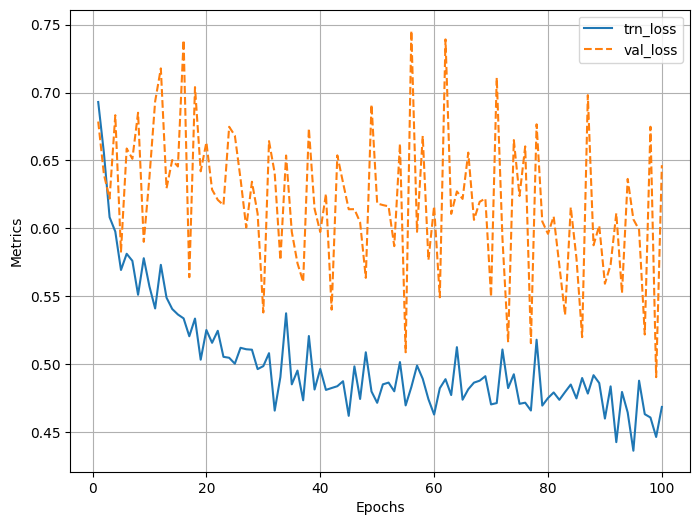

100%|██████████| 201/201 [00:00<00:00, 1768.73it/s]


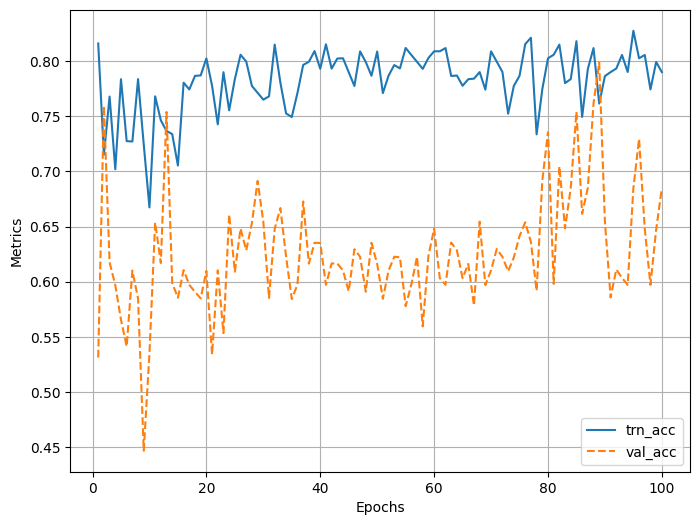

In [17]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

### Evaluate the model

In [50]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc  = 0
    for bx, data in enumerate(testload):
        loss, acc  = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc  += acc
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    return(mean_loss, mean_acc)

(loss, acc) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

Loss: 0.572122 Acc: 0.760417


### Cohen's Kappa statistics

In [51]:
# Cohen's Kappa statistics

def Kappa(model, testload, device):
    model.eval()
    y_true = []
    y_pred = []
    for data in testload:
        ims, targets = data
        ims     = ims.to(device=device)
        targets = targets.to(device=device)
        preds   = model(ims)
        pred_labels = torch.max(preds, 1)[1] # same as argmax
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(pred_labels.cpu().numpy())
    
    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa

kappa = Kappa(model, testload, device)
print('Kappa: {:.6f}'.format(kappa))

Kappa: 0.366721


In [52]:
# # Count the number of samples per class in the training set

# from collections import Counter

# total_counts = Counter()

# for _, targets in trainload:
#     total_counts.update(targets.cpu().numpy())

# print("Total counts per class in the training set:", total_counts)


### Save the model

In [53]:
# torch.save(model.to('cpu').state_dict(), model_name)

### Visualize activations at the output of the last convolutional block for a given image

In [54]:
image, target = trainset[0]
image.size()

torch.Size([3, 224, 224])

In [55]:
image   = image.unsqueeze(0).to(device)

In [56]:
def get_corelnet_feature_map(model, input_tensor: torch.Tensor) -> torch.Tensor:
    """
    Simple method: Extract feature map by calling model.features directly
    
    Args:
        model: CorelNet model instance  
        input_tensor: Input tensor
    
    Returns:
        Feature map from the feature extractor (before flattening)
    """
    model.eval()
    with torch.no_grad():
        feature_map = model.features(input_tensor)
    return feature_map

In [57]:
def visualize_corelnet_features(feature_map: torch.Tensor, 
                               max_channels: int = 16,
                               start_channel: int = 0,
                               figsize: tuple = (15, 10),
                               sample_idx: int = 0):
    """
    Visualize CorelNet feature maps
    
    Args:
        feature_map: Feature map tensor (batch_size, channels, height, width)
        max_channels: Maximum number of channels to display
        start_channel: Starting channel index (0-based)
        figsize: Figure size for matplotlib
        sample_idx: Which sample from the batch to visualize
    """
    if feature_map.dim() == 4:
        feature_map_sample = feature_map[sample_idx]  # Shape: (channels, height, width)
    else:
        feature_map_sample = feature_map
    
    total_channels = feature_map_sample.shape[0]
    end_channel = min(start_channel + max_channels, total_channels)
    num_channels = end_channel - start_channel
    
    if start_channel >= total_channels:
        raise ValueError(f"start_channel ({start_channel}) must be less than total channels ({total_channels})")
    
    print(f"Feature map shape: {feature_map.shape}")
    print(f"Total channels: {total_channels}")
    print(f"Visualizing channels {start_channel}-{end_channel-1} from sample {sample_idx}")
    
    
    # Calculate grid dimensions
    cols = 4
    rows = (num_channels + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i in range(num_channels):
        ax = axes[i]
        channel_idx = start_channel + i
        channel_data = feature_map_sample[channel_idx].cpu().numpy()
        
        im = ax.imshow(channel_data, cmap='viridis')
        ax.set_title(f'Channel {channel_idx}\nMin: {channel_data.min():.2f}\nMax: {channel_data.max():.2f}', 
                    fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.6)
    
    # Hide unused subplots
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'CorelNet Feature Maps - Channels {start_channel}-{end_channel-1}\nShape: {feature_map.shape}', 
                 fontsize=14)
    plt.tight_layout()
    plt.show()

Feature map shape: torch.Size([1, 16, 56, 56])
Total channels: 16
Visualizing channels 8-15 from sample 0


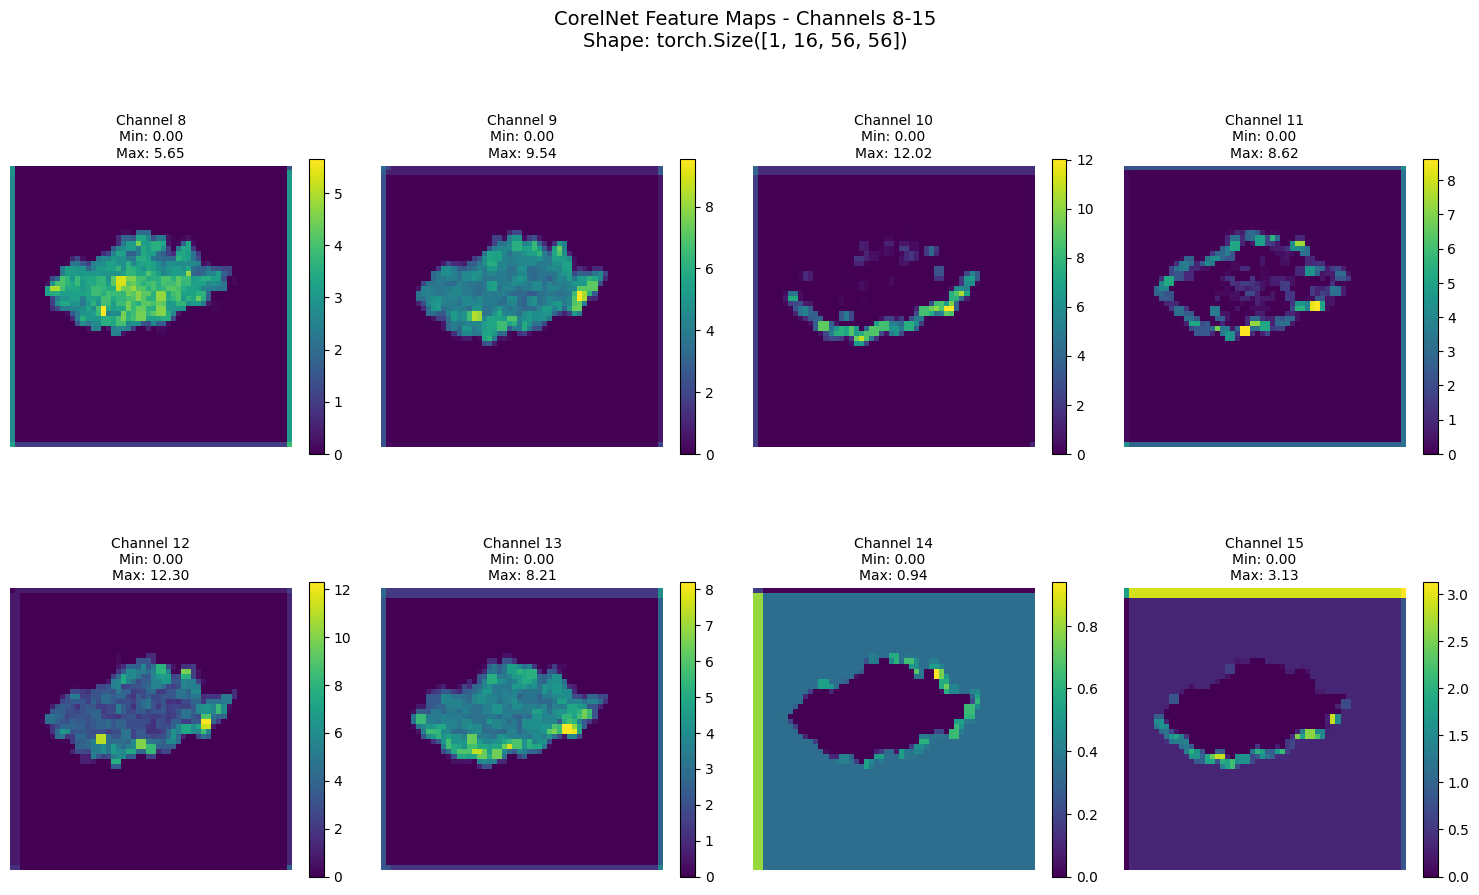

In [58]:
featmap = get_corelnet_feature_map(model,image)
visualize_corelnet_features(featmap, max_channels=8, start_channel=8)

Image path: ../larvae/000002_00001054.png
Predicted label for the single image: 2


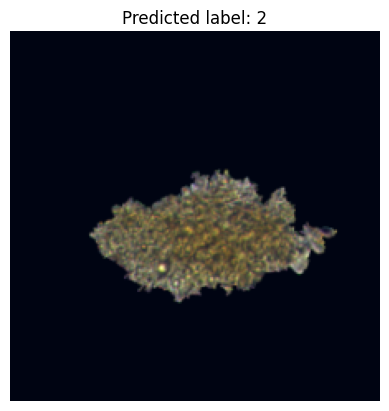

In [59]:
# Test model with a single image
def test_single_image(model, image, device):
    model.eval()
    image = image.to(device=device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension
        pred_label = torch.argmax(output, dim=1).item()
    return pred_label

# Example usage
image_idx = 0  # Index of the image you want to test
image, target = trainset[image_idx]  # Get the first image from the dataset
predicted_label = test_single_image(model, image, device)
print(f"Image path: {trainset.dataset[image_idx]}")
print(f"Predicted label for the single image: {predicted_label + 1}")
# Show image with predicted label
image = image.permute(1, 2, 0).numpy()
image = 255 * (image - np.min(image)) / (np.max(image) -np.min(image))
image = image.astype('uint8')
plt.imshow(image)
plt.title(f"Predicted label: {predicted_label + 1}")
plt.axis('off')
plt.show()

### Visualizar as projeções tSNE/UMAP da última camada convolucional e das camadas densas

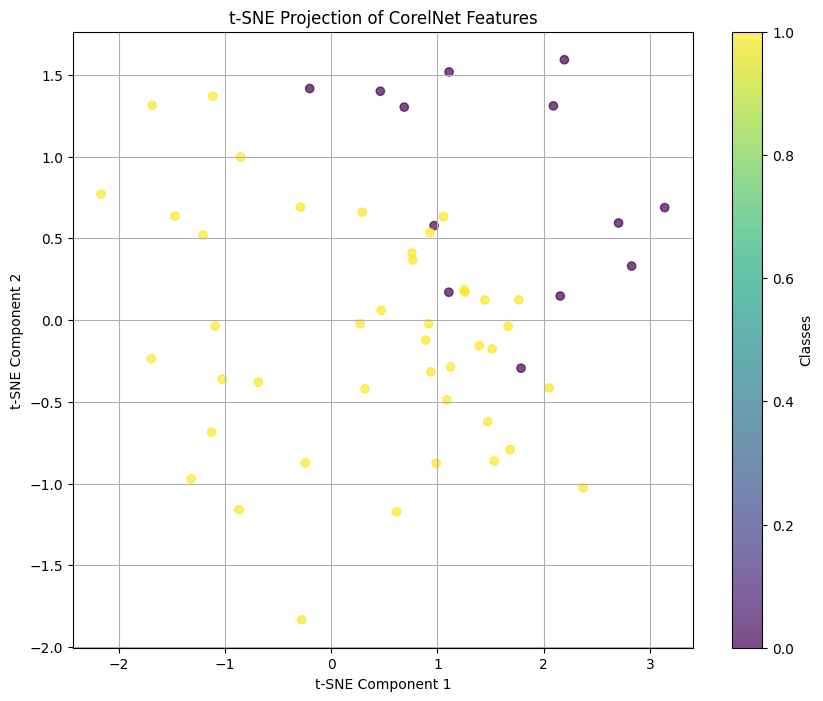

In [60]:
# tSNE Projection

from sklearn.manifold import TSNE

def tsne_projection(model, dataloader, device, n_components=2, perplexity=30, n_iter=1000):
    model.eval()
    with torch.no_grad():
        features = []
        labels = []
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model.features(inputs)
            features.append(outputs.cpu())
            labels.append(targets.cpu())
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    tsne = TSNE(n_components=n_components, perplexity=perplexity)
    reduced_features = tsne.fit_transform(features.reshape(features.size(0), -1).numpy())
    return reduced_features, labels.numpy()

reduced_features, labels = tsne_projection(model, testload, device, n_components=2, perplexity=30)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Classes')
plt.title('t-SNE Projection of CorelNet Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()

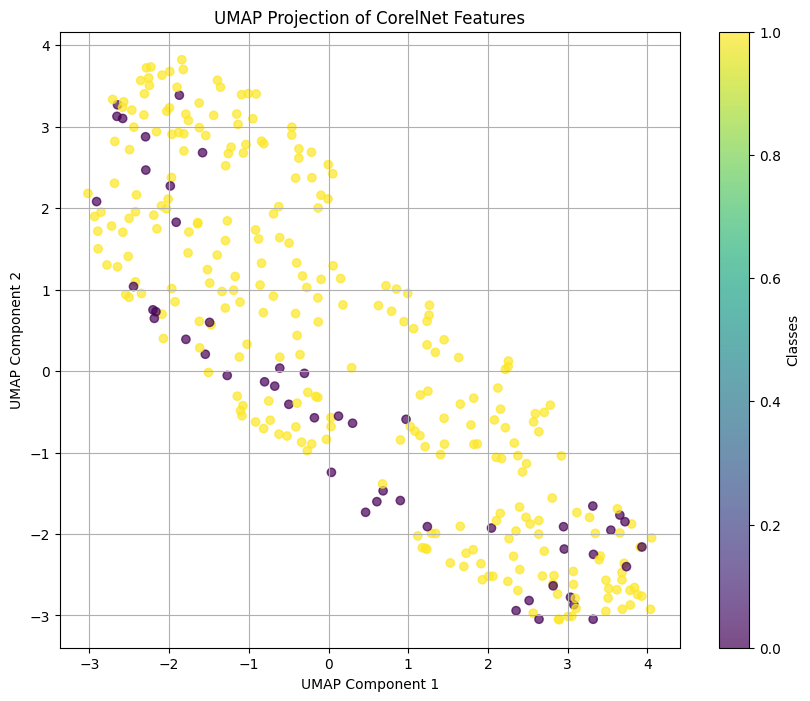

In [61]:
# Using UMAP for dimensionality reduction

import umap

def umap_projection(model, dataloader, device, n_components=2, n_neighbors=15, min_dist=0.1):
    model.eval()
    with torch.no_grad():
        features = []
        labels = []
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model.features(inputs)
            features.append(outputs.cpu())
            labels.append(targets.cpu())
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
    #reduced_features = reducer.fit_transform(features.view(features.size(0), -1).numpy())
    reduced_features = reducer.fit_transform(features.reshape(features.size(0), -1).numpy())
    return reduced_features, labels.numpy()

reduced_features_umap, labels_umap = umap_projection(model, trainload, device, n_components=2, n_neighbors=15, min_dist=0.1)
plt.figure(figsize=(10, 8))
scatter_umap = plt.scatter(reduced_features_umap[:, 0], reduced_features_umap[:, 1], c=labels_umap, cmap='viridis', alpha=0.7)
plt.colorbar(scatter_umap, label='Classes')
plt.title('UMAP Projection of CorelNet Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()